<a href="https://colab.research.google.com/github/anjali-ii/NLP/blob/main/Speaker_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
try:
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram
except:
    !pip install spela
    from spela.spectrogram import Spectrogram 
    from spela.melspectrogram import Melspectrogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
tf.compat.v1.disable_eager_execution()
# Get the data directories
data_dir = "/content/drive/MyDrive/16000_pcm_speeches"

In [6]:
os.listdir(data_dir)

['tf_Wav_reader.py',
 'other',
 'Nelson_Mandela',
 'Julia_Gillard',
 'Jens_Stoltenberg',
 'Magaret_Tarcher',
 '_background_noise_',
 'Benjamin_Netanyau']

In [8]:
# for now we are concerned with the four speakers
# lets get as a sample data from one of the speakers
nelson_madela = [item for item in os.listdir(data_dir + "/Nelson_Mandela")]
nelson_madela[:10]

['1456.wav',
 '1450.wav',
 '1448.wav',
 '1453.wav',
 '1437.wav',
 '1440.wav',
 '1454.wav',
 '1443.wav',
 '1433.wav',
 '144.wav']

In [9]:
def compute_spectrogram_melspectrogram_and_plot(wav_dir, compute_type):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
        wav_decoder, feed_dict={
            wav_filename_placeholder: wav_dir
        }).audio.flatten()
        sess.close()
    # audio has a sample rate of 16000 and the produced wav has a shape of (16000, 1)
    # reshape to (1, 1600)
    wav = wav_data.reshape(1, 16000)
    wav_new = wav[np.newaxis, :] # introduce a new axis to have a shape of (1, 1, 16000)
    height = wav_new.shape[1]
    width = wav_new.shape[2]
    # create a model to compute spectrogram
    model = tf.keras.Sequential() 
    if compute_type == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(height, width),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif compute_type == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(height, width), return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   
    # producing a spectrogram/melspectrogram from the model
    pred = model.predict(x=wav_new)

    if tf.keras.backend.image_data_format() == "channel_first":
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]

    # show the spectrogram/melspectrogram
    librosa.display.specshow(result, y_axis='linear', sr=16000)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


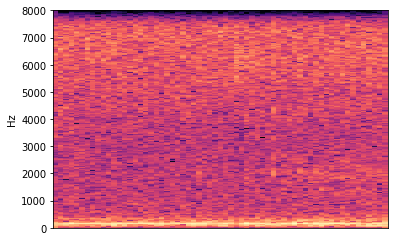

In [11]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "/Nelson_Mandela/" + nelson_madela[0], "spectrogram")

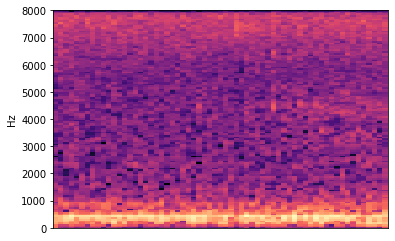

In [12]:
compute_spectrogram_melspectrogram_and_plot(data_dir + "/Nelson_Mandela/" + nelson_madela[0], "melspectrogram")

Train dataset

In [13]:
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [15]:
nelson_mandela_paths = get_wav_paths("/Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths("/Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths("/Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( '/Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths("/Julia_Gillard")

In [16]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir +speaker + "/"+ wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000))
        sess.close()
    return wav_data
    


In [17]:
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels

In [18]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, "/Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, "/Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, "/Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, "/Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, "/Julia_Gillard", 4) 

100%|██████████| 1501/1501 [05:52<00:00,  4.26it/s]


In [19]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [20]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels

In [21]:
# split the dataset into trainin and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(all_wavs, all_labels, test_size=0.2)

In [22]:
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [23]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [24]:
# create a model
def create_model(speech_feature):
    model = tf.keras.Sequential()
    if speech_feature == "spectrogram":
        model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=(1, 16000),
                            return_decibel_spectrogram=True, power_spectrogram=2.0,
                            trainable_kernel=False, name='static_stft'))
    elif speech_feature == "melspectrogram":
        model.add(Melspectrogram(sr=16000, n_mels=128,n_dft=512, n_hop=256,
                            input_shape=(1 , 16000),return_decibel_melgram=True,
                            trainable_kernel=False, name='melgram'))
   

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4)
            , loss = "categorical_crossentropy"
            , metrics = ["accuracy"])
    return model

In [25]:
# spectrogam model
model = create_model("spectrogram")

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 static_stft (Spectrogram)   (None, 257, 63, 1)        263168    
                                                                 
 conv2d (Conv2D)             (None, 255, 61, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 30, 64)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 243840)            0         
                                                                 
 dense (Dense)               (None, 5)                 1219205   
                                                                 
Total params: 1,483,013
Trainable params: 1,483,013
Non-trainable params: 0
____________________________________________

In [27]:
model.fit(x=train_x, y=train_y, epochs=10, validation_data=(test_x, test_y))

Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - ETA: 0s - loss: 21.2264 - accuracy: 0.6232

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6000/6000 [==============================] - 128s 21ms/sample - loss: 21.2264 - accuracy: 0.6232 - val_loss: 0.2965 - val_accuracy: 0.9133
Epoch 2/10
6000/6000 [==============================] - 129s 21ms/sample - loss: 0.2701 - accuracy: 0.9328 - val_loss: 0.2988 - val_accuracy: 0.9120
Epoch 3/10
6000/6000 [==============================] - 120s 20ms/sample - loss: 0.1270 - accuracy: 0.9638 - val_loss: 1.3097 - val_accuracy: 0.7707
Epoch 4/10
6000/6000 [==============================] - 119s 20ms/sample - loss: 0.1674 - accuracy: 0.9585 - val_loss: 0.9436 - val_accuracy: 0.8513
Epoch 5/10
6000/6000 [==============================] - 119s 20ms/sample - loss: 0.0471 - accuracy: 0.9842 - val_loss: 0.2579 - val_accuracy: 0.9427
Epoch 6/10
6000/6000 [==============================] - 117s 20ms/sample - loss: 0.0734 - accuracy: 0.9795 - val_loss: 0.4672 - val_accuracy: 0.9060
Epoch 7/10
6000/6000 [==============================] - 119s 20ms/sample - loss: 0.0342 - accuracy: 0.9883 - val_los

In [28]:
# melspectrogram model
model = create_model("melspectrogram")

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 melgram (Melspectrogram)    (None, 128, 63, 1)        296064    
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 61, 64)       640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 120960)            0         
                                                                 
 dense_1 (Dense)             (None, 5)                 604805    
                                                                 
Total params: 901,509
Trainable params: 901,509
Non-trainable params: 0
________________________________________________

In [30]:
model.fit(x=train_x, y=train_y, epochs=10, validation_data=(test_x, test_y))

Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - 76s 13ms/sample - loss: 11.7661 - accuracy: 0.6920 - val_loss: 2.0250 - val_accuracy: 0.7993
Epoch 2/10
6000/6000 [==============================] - 77s 13ms/sample - loss: 1.5424 - accuracy: 0.8392 - val_loss: 1.7718 - val_accuracy: 0.8307
Epoch 3/10
6000/6000 [==============================] - 75s 12ms/sample - loss: 1.4119 - accuracy: 0.8725 - val_loss: 2.4098 - val_accuracy: 0.8093
Epoch 4/10
6000/6000 [==============================] - 77s 13ms/sample - loss: 0.9768 - accuracy: 0.9010 - val_loss: 1.4392 - val_accuracy: 0.8640
Epoch 5/10
6000/6000 [==============================] - 74s 12ms/sample - loss: 0.6721 - accuracy: 0.9220 - val_loss: 2.1633 - val_accuracy: 0.8100
Epoch 6/10
6000/6000 [==============================] - 76s 13ms/sample - loss: 0.2623 - accuracy: 0.9595 - val_loss: 0.6429 - val_accuracy: 0.9267
Epoch 7/10
6000/6000 [==============================] - 74s 12m